# Talk about Framing and outlining the problem (Business problem and specifics)
# Talk about data

# Will it be delayed?

Everyone who has flown has experienced a delayed or cancelled flight. Both airlines and airports would like to improve their on-time performance and predict when a flight will be delayed or cancelled several days in advance. You are being hired to build a model that can predict if a flight will be delayed. To learn more, you must schedule a meeting with your client (me). To schedule an appointment with your client, send an event request through Google Calendar for a 15 minute meeting. Both you and your project partner must attend the meeting. Come prepared with questions to ask your client. Remember that your client is not a data scientist and you will need to explain things in a way that is easy to understand. Make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

For this project you must go through most all steps in the checklist. You must write responses for all items as done in the homeworks, however sometimes the item will simply be "does not apply". Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Some changes to the checklist:

* Do not do the final part (launching the product).
* Your presentation will be done as information written in this document in a dedicated section (no slides or anything like that). It should include high-level summary of your results (including what you learned about the data, the "accuracy" of your model, what features were important, etc). It should be written for your client, not your professor or teammates. It should include the best summary plots/graphics/data points.
* The models and hyperparameters you should consider during short-listing and fine-tuning will be released at a later time (dependent on how far we get over the next two weeks).
* Data retrieval must be automatic as part of the code (so it can easily be re-run and grab the latest data). Do not commit any data to the repository.
* Your submission must include a pickled final model along with this notebook.


# Notes

* gov agency tasked with improving efficiency with comercial airtraffic from consumer standpoint, 
* predict delays and errors 7 days in advanced
* data is from the 80s, subitted take off, supposed to leave, etc, on BTS (get a link) only look at 2023 and 2024
* less predictions but more accurate predictions by a 1/4
* National Air System (group that runs opperations at a single airport, makes all decisions so something they do can cause a run down, weather issues, security (TSA, bad person on deck), late arrival, cancelations,  ) broken down into minor, medium, major categories
* Things to ignore in data, diverted, international destination or arrival (only USA to USA)

In [1]:
!pip install numpy scipy pandas matplotlib scikit-learn pyarrow fastparquet seaborn 


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
# All of your imports here (you may need to add some)
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import pyarrow as pa
import fastparquet as fp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import glob

In [2]:
def read_csv(file_path):
    """Reads a CSV file and returns its content as a Pandas DataFrame."""
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
    
    return None

def label_delay(minutes):
    if minutes < 15:
        pass
    elif 15 <= minutes < 60:
        return 'Minor'
    elif 60 <= minutes < 180:
        return 'Medium'
    elif minutes >= 180:
        return 'Major'
    else:
        return 'Unknown'

# Frame problem, get data, explore

# Combing all the files into one for each year


In [3]:
import os

if os.path.exists('2023_combined_data.parquet'):
    print("The file '2023_combined_data.parquet' already exists. Skipping file creation.")
else:
    #Read in all the CSV files in the 2023_Data folder
    file_paths = glob.glob('2023_Data/*.csv')

    # Combine all the data into a single DataFrame
    data_frames = [pd.read_csv(file_path) for file_path in file_paths]
    combined_df = pd.concat(data_frames, ignore_index=True)

    #saving the combined data to a parquet file
    combined_df.to_parquet('2023_combined_data.parquet')


The file '2023_combined_data.parquet' already exists. Skipping file creation.


In [4]:
if os.path.exists('2024_combined_data.parquet'):
    print("The file '2024_combined_data.parquet' already exists. Skipping file creation.")
else:
    #Read in all the CSV files in the 2023_Data folder
    file_paths = glob.glob('2024_Data/*.csv')

    # Combine all the data into a single DataFrame
    data_frames = [pd.read_csv(file_path) for file_path in file_paths]
    combined_df = pd.concat(data_frames, ignore_index=True)

    #saving the combined data to a parquet file
    combined_df.to_parquet('2024_combined_data.parquet')

The file '2024_combined_data.parquet' already exists. Skipping file creation.


In [5]:
if os.path.exists('combined_data.parquet'):
    print("The file 'combined_data.parquet' already exists. Skipping file creation.")
else:
    # Read the parquet files
    data_2023 = pd.read_parquet('2023_combined_data.parquet')
    data_2024 = pd.read_parquet('2024_combined_data.parquet')
    combined_data = pd.concat([data_2023, data_2024], ignore_index=True)

    # Save the combined data to a new parquet file
    combined_data.to_parquet('combined_data.parquet')

    # Shape and preview
    print(combined_data.shape)
    combined_data.head()


The file 'combined_data.parquet' already exists. Skipping file creation.


In [6]:
# #dropping Diverted data
if os.path.exists('cleaned_data.parquet'):
    print("The file 'cleaned_data.parquet' already exists. Skipping data cleaning.")
    X = pd.read_parquet('cleaned_data.parquet')
else:
# Import the Parquet file
    train = pd.read_parquet('combined_data.parquet')

    # List of columns to remove
    columns_to_remove = [
    'Diverted',  # First, drop the main DIVERTED column
    'DivAirportLandings', 'DivReachedDest', 'DivActualElapsedTime', 
    'DivArrDelay', 'DivDistance', 'Div1Airport', 'Div1WheelsOn', 'Div1TotalGTime', 
    'Div1LongestGTime', 'Div1WheelsOff', 'Div1TailNum',
    'Div1AirportID', 'Div1AirportSeqID',
    'Div1TotalGTime', 'Div1LongestGTime', 'Div2Airport', 'Div2WheelsOn', 
    'Div2TotalGTime', 'Div2LongestGTime', 'Div2WheelsOff', 'Div2TailNum','Div2AirportID', 'Div2AirportSeqID', 'Div2TotalGTime', 'Div2LongestGTime', 
    'Div3Airport', 'Div3WheelsOn', 'Div3TotalGTime', 'Div3LongestGTime', 'Div3WheelsOff', 
    'Div3TailNum','Div3AirportID', 'Div3AirportSeqID', 'Div3TotalGTime', 'Div3LongestGTime', 
    'Div4Airport', 'Div4WheelsOn', 'Div4TotalGTime', 'Div4LongestGTime', 'Div4WheelsOff', 
    'Div4TailNum', 'Div4AirportID', 'Div4AirportSeqID', 'Div4TotalGTime', 'Div4LongestGTime', 
    'Div5Airport', 'Div5WheelsOn', 'Div5TotalGTime', 'Div5LongestGTime', 'Div5WheelsOff', 
    'Div5TailNum', 'Div5AirportID', 'Div5AirportSeqID', 'Div5TotalGTime', 'Div5LongestGTime'
    ]

    # Drop the specified columns
    X = train.drop(columns=columns_to_remove, errors='ignore')  # Use errors='ignore' to prevent issues if columns don't exist

    # Save the cleaned DataFrame to a new Parquet file
    X.to_parquet('cleaned_data.parquet')

    # Shape and preview
    print(X.shape)  # Check new shape
    print(X.dtypes)  # Check data types


The file 'cleaned_data.parquet' already exists. Skipping data cleaning.


In [7]:
#print the cleaned data
X.head()


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,Duplicate,Unnamed: 119
0,2023,3,9,24,7,2023-09-24,B6,B6,20409,B6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
1,2023,3,9,24,7,2023-09-24,B6,B6,20409,B6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
2,2023,3,9,24,7,2023-09-24,B6,B6,20409,B6,...,66.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,N,NaN
3,2023,3,9,24,7,2023-09-24,B6,B6,20409,B6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
4,2023,3,9,24,7,2023-09-24,B6,B6,20409,B6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN


# Maybe Linear Regression

* Things to ignore in data, diverted, international destination or arrival (only USA to USA)

In [8]:
train_set = pd.read_parquet('cleaned_data.parquet')
train_sample = train_set.sample(n=1000, random_state=42)
train_sample['DelayCategory'] = train_sample['DepDelayMinutes'].apply(label_delay)

X = train_sample.copy()

train_sample.head(15)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,Duplicate,Unnamed: 119,DelayCategory
12567694,2024,4,11,17,7,2024-11-17,B6,B6,20409,B6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,None
5200611,2023,2,4,26,3,2023-04-26,WN,WN,19393,WN,...,0.0,33.0,0.0,113.0,NaN,NaN,NaN,N,NaN,Medium
4422418,2023,3,7,2,7,2023-07-02,AS,AS_CODESHARE,19930,AS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,None
10361752,2024,1,2,4,7,2024-02-04,WN,WN,19393,WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,None
11577393,2024,1,3,15,5,2024-03-15,AA,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,None
653488,2023,4,11,21,2,2023-11-21,UA,UA_CODESHARE,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,Minor
2818923,2023,3,8,15,2,2023-08-15,AA,AA_CODESHARE,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,None
14315539,2024,2,4,1,1,2024-04-01,AA,AA_CODESHARE,19805,AA,...,5.0,13.0,0.0,0.0,NaN,NaN,NaN,N,NaN,None
5771162,2023,1,2,16,4,2023-02-16,UA,UA,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,None
14202508,2024,4,10,26,6,2024-10-26,F9,F9,20436,F9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,None


In [9]:
#droping all the FIPS numbers outside of the US (1-56) 

us_fips_codes = {1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,
                21,22,23,24,25,26,27,28,29,30,31,32,33,34,
                35,36,37,38,39,40,41,42,44,45,46,47,48,49,
                50,51,53,54,55,56}

train_sample_filtered = train_sample[
    train_sample['OriginStateFips'].isin(us_fips_codes) &
    train_sample['DestStateFips'].isin(us_fips_codes)
]

train_sample_filtered.shape
# train_sample_filtered.head()
train_sample_filtered


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,Duplicate,Unnamed: 119,DelayCategory
12567694,2024,4,11,17,7,2024-11-17,B6,B6,20409,B6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,None
5200611,2023,2,4,26,3,2023-04-26,WN,WN,19393,WN,...,0.0,33.0,0.0,113.0,NaN,NaN,NaN,N,NaN,Medium
4422418,2023,3,7,2,7,2023-07-02,AS,AS_CODESHARE,19930,AS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,None
10361752,2024,1,2,4,7,2024-02-04,WN,WN,19393,WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,None
11577393,2024,1,3,15,5,2024-03-15,AA,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9715452,2024,4,12,7,6,2024-12-07,AS,AS_CODESHARE,19930,AS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,None
14465988,2024,2,4,2,2,2024-04-02,UA,UA,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,None
3322192,2023,2,6,21,3,2023-06-21,UA,UA,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,None
7513695,2024,2,6,1,6,2024-06-01,AA,AA,19805,AA,...,0.0,0.0,0.0,31.0,NaN,NaN,NaN,N,NaN,Minor


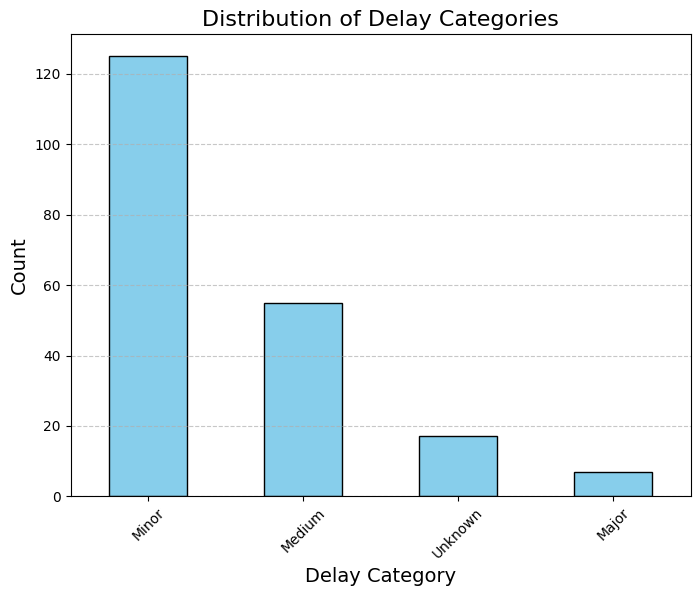

In [10]:
# Count the occurrences of each DelayCategory
delay_counts = train_sample_filtered['DelayCategory'].value_counts()

# Plot the bar graph
plt.figure(figsize=(8, 6))
delay_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Delay Categories', fontsize=16)
plt.xlabel('Delay Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

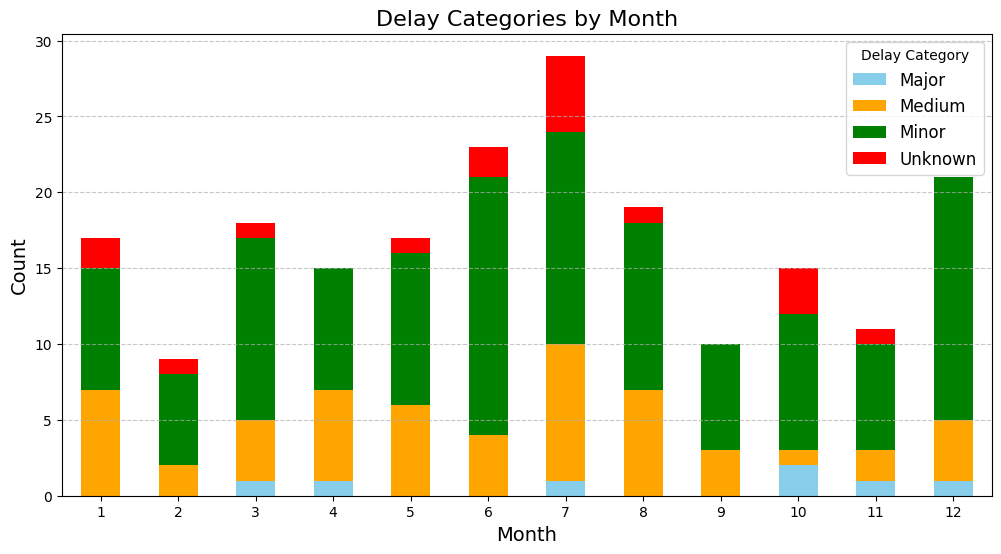

In [12]:
# Count the occurrences of each DelayCategory during each month
delay_counts_by_month = train_sample_filtered.groupby(['Month', 'DelayCategory']).size()
# Create a histogram for the delay counts by month
delay_counts_by_month.unstack().plot(kind='bar', stacked=True, figsize=(12, 6), color=['skyblue', 'orange', 'green', 'red'])
plt.title('Delay Categories by Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Delay Category', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

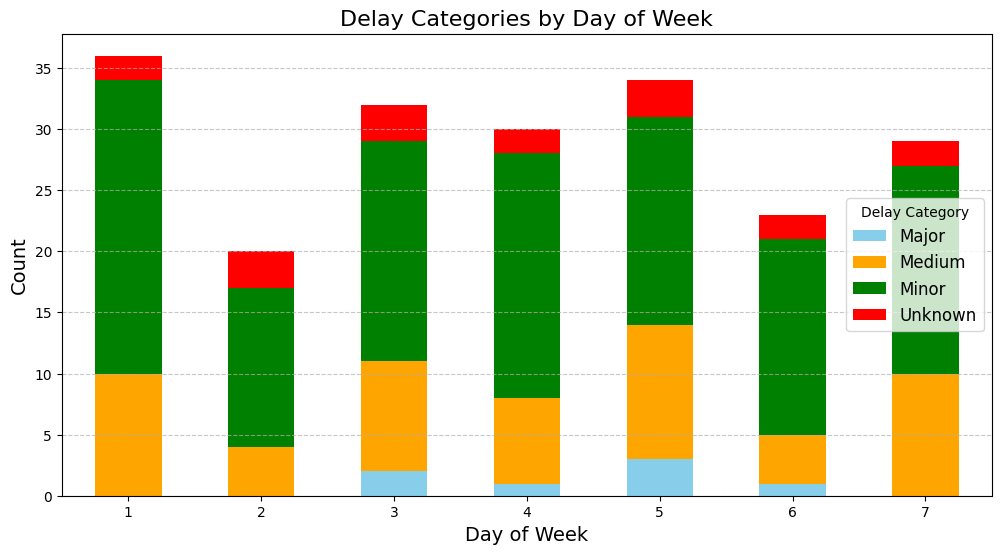

In [13]:
# Create a graph to show the distribution of delays by day of week
delay_counts_by_day = train_sample_filtered.groupby(['DayOfWeek', 'DelayCategory']).size()
# Create a histogram for the delay counts by day of week
delay_counts_by_day.unstack().plot(kind='bar', stacked=True, figsize=(12, 6), color=['skyblue', 'orange', 'green', 'red'])
plt.title('Delay Categories by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Delay Category', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()